# CW2

In [51]:
import trimesh
import sys, os
import pyrender
import numpy as np
from scipy import sparse
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from scipy.sparse import linalg, identity

In [2]:
## loading cell
def load_mesh(path):
    mesh_fp = os.path.join(path)
    assert os.path.exists(mesh_fp), 'cannot found:'+mesh_fp 
    mm = trimesh.load(mesh_fp) 
    return mm

def convert_color(k, offset):
    ''' 
    get rgba color from curvature
    Since there might be boundarys with extremely high curvature,
    Adapted histogram equalization from 
    https://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy
    '''
    # Normalize curvature to [0, 1]
    k -= np.min(k)
    k /= np.max(k)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    # Histogram Equalization
    hist, bins = np.histogram(k, offset, [0, 1])
    cdf = hist.cumsum()
    cdf = cdf / cdf[-1]
    k = np.interp(k, bins[:-1], cdf)
    m = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    return m.to_rgba(k)

In [3]:
def Display(mm):
    scene = pyrender.Scene(ambient_light=0.5*np.array([1.0, 1.0, 1.0, 1.0]))
    mesh = pyrender.Mesh.from_trimesh(mm)
    scene.add(mesh)
    v=pyrender.Viewer(scene, use_raymond_lighting=True)

# Display(mm) # New window
#trimesh.Scene(mm).show() # or this for showing in notebook, colors may look odd (bug)?

## 1. Uniform discretization

In [4]:
# Constructing the M and C matrix for the uniform discretization
def get_M_inv_uniform(mesh):
    neighbors = mesh.vertex_neighbors
    size = len(neighbors)
    nei_mat = sparse.spdiags([1/len(x) for x in neighbors], 0, size, size)
    return nei_mat

def get_C_uniform(mesh):
    size = len(mesh.vertices)
    neighbors = mesh.vertex_neighbors
    row = []
    col = []
    data = []
    for i in range(size):
        col.append(i)                         # for index of i
        col.extend(neighbors[i])              # for index of neighbors of i
        row.extend([i]*(len(neighbors[i])+1)) # at i th row, (len + 1) entries 
        data.append(-len(neighbors[i]))       # first add diagonal value -N
        data.extend([1]*len(neighbors[i]))    # 1 at all neighbor indices
    mat = sparse.csr_matrix((data, (row, col)), shape=(size, size))
    return mat

In [5]:
def get_mean_curvature_uniform(mesh):
    '''
    Calculate the mean curvature of a mesh using the uniform discretisation
    '''
    M_inv = get_M_inv_uniform(mesh)
    C = get_C_uniform(mesh)
    vertices = np.asarray(mesh.vertices)
    minus_two_H_n = M_inv@C@vertices
    H = np.linalg.norm(minus_two_H_n / 2, axis=1)
    return H


In [6]:
def angles(mesh):
    '''
    Get sum of angles for each vertex in the mesh
    '''
    thetas = np.zeros(mesh.vertices.shape[0])
    for face, angles in zip(mesh.faces, mesh.face_angles):
        thetas[face] += angles

    return thetas

def barycentric_face_area(a, b, c):
    # for points a, b, c
    # half of the cross product length
    # 1/3 because using barycentric
    return 1/3 * 0.5 * np.linalg.norm(np.cross(b - a, c - a))

def areas(mesh):
    '''
    Get the sum of area for each vertex
    '''
    A_is = np.zeros(mesh.vertices.shape[0])
    vertices = mesh.vertices
    for face in mesh.faces:
        # for each face, three angles are added at the three vertex indicated by the mesh.faces index
        a_idx, b_idx, c_idx = face[0], face[1], face[2]
        A_is[a_idx] += barycentric_face_area(vertices[a_idx], vertices[b_idx], vertices[c_idx])
        A_is[b_idx] += barycentric_face_area(vertices[b_idx], vertices[c_idx], vertices[a_idx])
        A_is[c_idx] += barycentric_face_area(vertices[c_idx], vertices[a_idx], vertices[b_idx])
    
    return A_is

def get_gauss_curvature(mesh):
    '''
    Calculate the Gaussian curvature of a mesh using the uniform discretisation
    '''
    K = (2 * np.pi - angles(mesh)) / areas(mesh)
    return K


In [7]:
def save_colored_mesh(mesh, curvature, disp=False, path=None, offset=5000):
    '''
    Display, show or save the colored mesh
    '''
    H = curvature(mesh)
    mesh.visual.vertex_colors = convert_color(H, offset)
    # trimesh.Scene(mesh).show()
    if disp:
        Display(mesh)
    mesh.export(path)


plane = load_mesh('./meshes/curvatures/plane.obj')
lilium =load_mesh('./meshes/curvatures/lilium.obj')
save_colored_mesh(plane, get_mean_curvature_uniform, path='./generated/plane_H.obj') # plane, uniform mean
save_colored_mesh(lilium, get_mean_curvature_uniform, path='./generated/lilium_H.obj') # lilium, uniform mean
save_colored_mesh(plane, get_gauss_curvature, disp=False, path='./generated/plane_K.obj') # plane, uniform gaussian
save_colored_mesh(lilium, get_gauss_curvature, disp=False, path='./generated/lilium_K.obj') # lilium, uniform gaussian


## First and Second Fundamental forms

In [8]:
class ellipsoid:
    def __init__(self, a, b, c) -> None:
        self.a = a
        self.b = b
        self.c = c

    def p(self, u, v):
        x = self.a * np.cos(u) * np.sin(v)
        y = self.b * np.sin(u) * np.sin(v)
        z = self.c * np.cos(v)
        return x, y, z

    def Jacobian(self, u, v):
        x_u = np.array([-self.a * np.sin(u) * np.sin(v),
                         self.b * np.cos(u) * np.sin(v),
                         0])
        x_v = np.array([ self.a * np.cos(u) * np.cos(v),
                         self.b * np.sin(u) * np.cos(v),
                        -self.c * np.sin(v)])
        return x_u, x_v
    
    def Hessian(self, u, v):
        x_uu = np.array([-self.a * np.cos(u) * np.sin(v),
                         -self.b * np.sin(u) * np.sin(v),
                         0])
        x_uv = np.array([-self.a * np.sin(u) * np.cos(v),
                          self.b * np.cos(u) * np.cos(v),
                          0])
        x_vv = np.array([-self.a * np.cos(u) * np.sin(v),
                         -self.b * np.sin(u) * np.sin(v),
                         -self.c * np.cos(v)])
        return x_uu, x_uv, x_vv

    def normal(self, u, v):
        # normal to the tangent plane
        x_u, x_v = self.Jacobian(u, v)
        n = np.cross(x_u, x_v)
        return n / np.linalg.norm(n)

    def I(self, u, v):
        # first fundamental form
        x_u, x_v = self.Jacobian(u, v)
        E = x_u @ x_u
        F = x_u @ x_v
        G = x_v @ x_v
        return np.array([[E, F], [F, G]])

    def II(self, u, v):
        # second fundamental form
        x_uu, x_uv, x_vv = self.Hessian(u, v)
        n = self.normal(u, v)
        e = x_uu @ n
        f = x_uv @ n
        g = x_vv @ n
        return np.array([[e, f], [f, g]])
    
    def normal_curvature(self, p, t):
        '''
        Get the normal curvature at point p as a function of direction vector t
        t: [w1, w2]^T on the tangent plane, w1*x_u + w2*x_v
        p: (u, v)
        '''
        kn = t.T@self.II(p[0],p[1])@t / (t.T@self.I(p[0],p[1])@t)

        return kn

I =  [[4. 0.]
 [0. 9.]]
II =  [[1. 0.]
 [0. 1.]]


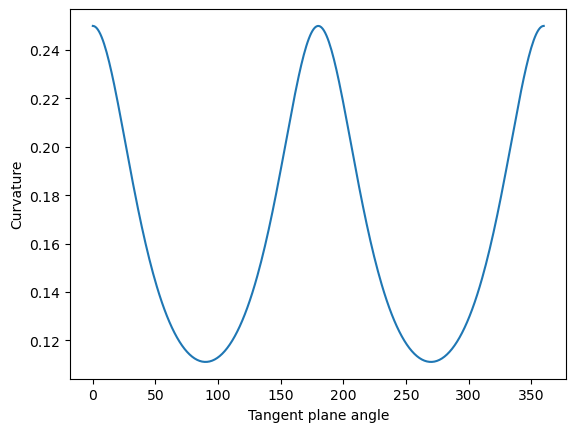

In [9]:
ellipsoid_example = ellipsoid(1, 2, 3)
# at (a, 0, 0), sin(v) = 1, sin(u) = 0, v = pi/2, u=0
point = [0, np.pi/2]
first_fundamental_form = ellipsoid_example.I(point[0], point[1])
second_fundamental_form = ellipsoid_example.II(point[0], point[1])
dir = np.linspace(0, 2 * np.pi, 360)
curvatures = np.zeros(360)
for i in range(len(dir)):
    t = np.array([np.cos(dir[i]), np.sin(dir[i])])
    c = ellipsoid_example.normal_curvature(point,t)
    curvatures[i] = c
plt.ylabel('Curvature')
plt.xlabel('Tangent plane angle')
plt.plot(dir*180 / np.pi, curvatures)
print("I = ", first_fundamental_form)
print("II = ", second_fundamental_form)

## Non-uniform (Discrete Laplace-Beltrami)

In [10]:
# Constructing the M and C matrix for the cotagent discretization
def get_M_inv_cot(mesh):
    vertices_area = areas(mesh)
    size = len(vertices_area)
    nei_mat = sparse.spdiags(vertices_area, 0, size, size)
    return nei_mat

def get_cot(v1, v2, mesh):
    '''
    get the 0.5 * cot alpha + cot beta for two vertices
    v1, v2: vertex index
    '''
    vfs = mesh.vertex_faces                  # get all the face index for each vertex
    ifaces = np.intersect1d(vfs[v1],vfs[v2]) # get the faces with the two vertex
    ifaces = ifaces[ifaces!=-1]              # -1 is padded so delete
    # print(ifaces)
    fvs = mesh.faces[ifaces]                 # get the two (or one) faces vertex list: like [[x,y,a],[x,b,y]]
    # print(fvs)
    num = np.array(fvs).shape[0]
    face_idx = np.array([0,1,2])             # for boolean calculation
    total_cot = 0
    for i in range(num):
        a = (fvs[i]!=v1)
        b = (fvs[i]!=v2)
        c = a & b                                # get true false boolean array where the other vertex place is True
        # print(c)
        idx = face_idx[c]                        # get the location of the other face vertex wrt the fvs list
        theta = mesh.face_angles[ifaces[i],idx]      # get the angle according to the other vertex's index
        total_cot += 1/np.tan(theta[0])
    return 0.5*total_cot

    
def get_C_cot(mesh):
    size = len(mesh.vertices)
    neighbors = mesh.vertex_neighbors
    row = [] # stored row index non-zero
    col = [] # stored col index non-zero
    data = []
    for i in range(size):
        if i % 100 == 0:
            print(i)
        col.append(i)                         # for index of i
        col.extend(neighbors[i])              # for index of neighbors of i
        row.extend([i]*(len(neighbors[i])+1)) # at i th row, (len + 1) entries 
        # compute cot alpha + cot beta for each pair of neighbor
        data_row = []
        for neighbor in neighbors[i]:
            cot = get_cot(i, neighbor, mesh)
            data_row.append(cot)
        data.append(-np.sum(data_row))       # -sum of non-diagonal in this row
        data.extend(data_row)                # the cot value for the pairs
        # print(data)
    mat = sparse.csr_matrix((data, (row, col)), shape=(size, size))
    return mat

In [11]:
def get_mean_curvature_cot(mesh):
    '''
    Calculate the mean curvature of a mesh using the uniform discretisation
    '''
    M_inv = get_M_inv_cot(mesh)
    C = get_C_cot(mesh)
    vertices = np.asarray(mesh.vertices)
    minus_two_H_n = M_inv@C@vertices
    H = np.linalg.norm(minus_two_H_n / 2, axis=1)
    return H

In [12]:
plane = load_mesh('./meshes/curvatures/plane.obj')
lilium =load_mesh('./meshes/curvatures/lilium.obj')
save_colored_mesh(plane, get_mean_curvature_cot, disp=False, path='./generated/plane_H_cot.obj') # plane, cot mean
save_colored_mesh(lilium, get_mean_curvature_cot, disp=False, path='./generated/lilium_H_cot.obj') # lilium, cot mean

0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300


## Model analysis

In [13]:
armadillo = load_mesh('./meshes/decomposition/armadillo.obj')
# Display(armadillo)

In [14]:
def eigen_basis(mesh, lap, k):
    '''
    # Change of basis: sum^k (xT ei) ei
    # ei is sorted from smallest eigenvalue
    '''
    # print("1")
    _, vec = linalg.eigs(lap, k=k, which='SM') # get first l smallest eigen value and its eigenvector
    vec = vec.real
    # print("2")
    out = mesh.copy()
    vertices = np.asarray(mesh.vertices)
    out_vertices = np.zeros(vertices.shape)
    ef = vertices.T @ vec
    for i in range(3):
        out_vertices[:, i] = np.sum(np.tile(ef[i], (vertices.shape[0], 1)) * vec, axis=1)
    out.vertices = out_vertices
    
    return out

def get_lap_cot(mesh):
    # just need compute once each mesh
    M_inv = get_M_inv_cot(mesh)
    C = get_C_cot(mesh)
    lap = M_inv@C
    return lap

def get_lap_uni(mesh):
    # just need compute once each mesh
    M_inv = get_M_inv_uniform(mesh)
    C = get_C_uniform(mesh)
    lap = M_inv@C
    return lap

In [85]:
armadillo_lap = get_lap_cot(armadillo)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [18]:
armadillo_k5 = eigen_basis(armadillo, armadillo_lap, 5)
armadillo_k5.export("./generated/armadillo_k5.obj")

'# https://github.com/mikedh/trimesh\nv -0.37055818 -0.81135860 -0.05962588\nv -0.11459020 0.02175766 -0.66211081\nv -0.37096287 -0.81231504 -0.05992110\nv -0.37030963 -0.81080143 -0.05949965\nv -0.06703993 0.39694194 -0.05116552\nv -0.06632558 0.39016341 -0.04780998\nv 0.15001488 0.22087081 0.00523942\nv 0.15424377 0.20478703 0.01380261\nv -0.02986314 0.55699396 -0.00049200\nv -0.11457237 0.02250270 -0.66083835\nv -0.11455088 0.02316655 -0.65967444\nv -0.11456863 0.02259814 -0.66063204\nv -0.11457738 0.02224354 -0.66123874\nv -0.11454946 0.02347526 -0.65918074\nv -0.11454352 0.02358145 -0.65897987\nv 0.54149296 0.24115658 -0.16484650\nv 0.53145403 0.24310627 -0.16048301\nv 0.53608729 0.24219523 -0.16251240\nv 0.05794558 -0.33489048 0.28477068\nv 0.23422518 -0.77746714 0.59199885\nv 0.53307571 0.24279068 -0.16118869\nv 0.54664611 0.23983086 -0.16723459\nv 0.53164380 0.24305851 -0.16056609\nv -0.07150676 0.27936311 -0.16249615\nv 0.53303042 0.24275741 -0.16122035\nv -0.07445762 0.375236

In [20]:
armadillo_k15 = eigen_basis(armadillo, armadillo_lap, 15)
# Display(armadillo_k15)
armadillo_k15.export("./generated/armadillo_k15.obj")

'# https://github.com/mikedh/trimesh\nv -0.27860304 -0.83252243 -0.06898995\nv 0.05946280 0.04438585 -0.68531258\nv -0.27883179 -0.83421675 -0.06931190\nv -0.27881777 -0.83230534 -0.06912777\nv -0.26363349 0.57012150 0.00991168\nv -0.27361933 0.57189051 0.03621370\nv 0.34444962 0.13253521 -0.05119012\nv 0.36112056 0.12250822 -0.01931792\nv 0.04115174 0.15775686 -0.09591944\nv 0.05794820 0.04439803 -0.68336112\nv 0.05657941 0.04450669 -0.68172191\nv 0.05767283 0.04441610 -0.68311308\nv 0.05839371 0.04440381 -0.68403724\nv 0.05597621 0.04440590 -0.68080609\nv 0.05574496 0.04447174 -0.68059027\nv 0.38385102 0.27140441 -0.19261651\nv 0.39361337 0.26971770 -0.19043073\nv 0.38846791 0.27050763 -0.19122828\nv 0.13670838 -0.28385004 0.25201166\nv 0.15278522 -0.87151338 0.55129760\nv 0.39192701 0.26998853 -0.19071935\nv 0.36672125 0.27195910 -0.18818066\nv 0.39304282 0.26974869 -0.19024157\nv -0.20330253 0.24697917 -0.24562477\nv 0.39000862 0.27002934 -0.19013373\nv -0.27621439 0.48931604 -0.09

In [86]:
armadillo_k1000 = eigen_basis(armadillo, armadillo_lap, 1000)
Display(armadillo_k1000)
armadillo_k1000.export("./generated/armadillo_k1000.obj")

# Laplacian Mesh Smoothing

## Explicit smoothing

In [20]:
def smoothing_ex(mesh, lap = None, lmbd=0.01, iter=100, lap_func = get_lap_uni):
    '''
    P(t+1) = P(t) + lmbd* L(P(t))
    smooth for iter iteration,
    requires small lambda for stability
    '''
    out = mesh.copy()
    out_vertices = np.asarray(mesh.vertices)
    if lap is None:
        lap = lap_func(mesh)

    for i in range(iter):
        out_vertices = out_vertices + lmbd * lap @ out_vertices
    
    out.vertices = out_vertices
    return out

In [16]:
cube = load_mesh('./meshes/cube.obj')
noisy_fandisk = load_mesh('./meshes/smoothing/fandisk_ns.obj')
fandisk_lap = get_lap_cot(noisy_fandisk)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200


In [22]:
lmbd_list = [0.01, 0.1, 0.5, 1, 5]
for lmbd in lmbd_list:
    print("lambda: ", lmbd)
    if lmbd <= 5:
        iter = 100
    else:
        iter = 10
    smoothed_cube = smoothing_ex(cube, lmbd = lmbd, lap_func=get_lap_cot)
    smoothed_fandisk = smoothing_ex(noisy_fandisk, lap=fandisk_lap, lmbd = lmbd, iter=iter)
    smoothed_cube.export("./generated/smooth_cube_"+str(lmbd)+".obj")
    smoothed_fandisk.export("./generated/smooth_fandisk_"+str(lmbd)+".obj")


lambda:  0.01
0
lambda:  0.1
0
lambda:  0.5
0
lambda:  1
0
lambda:  5
0


## Implicit smoothing

In [82]:
def smoothing_imp(mesh, M_inv=None, C=None, lmbd=0.01, iter=100, M_func=get_M_inv_uniform, C_func=get_C_uniform):
    '''
    No constriant for lmbd, but slower
    solves:
        P(t+1) = P(t) + lmbd*L(P(t+1))
        (I - lmbd*L)P(t+1) = p(t)
        (M - lmbd*C)P(t+1) = Mp(t)
    '''
    
    out_mesh = mesh.copy()
    out_vertices = np.asarray(mesh.vertices)
    if M_inv is None or C is None:
        M_inv = M_func(mesh)
        C = C_func(mesh)

    M_inverse = M_inv.copy()
    np.reciprocal(M_inverse.data, out=M_inverse.data) # diagonal matrix M
    M = M_inverse
    mat = M - lmbd * C
    vec =  M@out_vertices # Nx3
    
    for i in range(iter):
        out_vertices = linalg.spsolve(mat,vec)
        out_mesh.vertices = out_vertices

    return out_mesh

In [73]:
fandisk_M_inv = get_M_inv_cot(noisy_fandisk)
fandisk_C = get_C_cot(noisy_fandisk)

In [83]:
lmbd_list = [0.1, 1, 10, 50, 100, 500]
for lmbd in lmbd_list:
    print("lambda: ", lmbd)
    imp_smoothed_cube = smoothing_imp(cube, lmbd = lmbd, M_func=get_M_inv_cot, C_func=get_C_cot, iter=2)
    imp_smoothed_fandisk = smoothing_imp(noisy_fandisk, M_inv=fandisk_M_inv, C = fandisk_C, lmbd = lmbd)
    imp_smoothed_cube.export("./generated/imp_smooth_cube_"+str(lmbd)+".obj")
    imp_smoothed_fandisk.export("./generated/imp_smooth_fandisk_"+str(lmbd)+".obj")

lambda:  0.1
0
lambda:  1
0
lambda:  10
0
lambda:  50
0
lambda:  100
0
lambda:  500
0


## Data smoothing

In [95]:
clean_bunny = trimesh.load('meshes/bunny.obj')
vertices = clean_bunny.vertices
scale = np.max(vertices) - np.min(vertices)
# print(scale)
# print(clean_bunny.vertices)
# ad noise wrt scale
stds = np.linspace(0, 10, 10) * scale/1000

for std in stds:
    noises = np.random.normal(0, std, vertices.shape)

    noisy_bunny = clean_bunny.copy()
    noisy_bunny.vertices = vertices + noises
    noisy_bunny.export("./generated/noisy_bunny_"+str(std)+".obj")

    smooth_bunny = smoothing_imp(noisy_bunny, lmbd=1.5, M_func=get_M_inv_cot, C_func=get_C_cot)
    smooth_bunny.export("./generated/smoothed_bunny_"+str(std)+".obj")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
0
100
200
300
400
500
